# Altın Fiyatlarını Tahmin Etmek İçin Regresyon Modellerinin Performans Karşılaştırması

In [1]:
# Kullanılması gereken kütüpaneler.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil import parser
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.dates as mdates

# Model çalışmada çıkacak olan uyarıyı kapatmaya yarayan kod.
import warnings
warnings.filterwarnings('ignore')

In [7]:
# Veri seti okunmasını sağlayan kodu yazalım.
df = pd.read_csv(r'C:\Users\realb\Desktop\Global altın fiyatı analiz eden model/gld_price_data.csv')

In [36]:
# Veri setinin ilk beş setinin okumasını sağlayalım.
gold_price_df.head()

,SPX,GLD,USO,SLV,EUR/USD
0,1447.160034,84.860001,78.470001,15.180,1.471692
1,1447.160034,85.570000,78.370003,15.285,1.474491
2,1411.630005,85.129997,77.309998,15.167,1.475492
3,1416.180054,84.769997,75.500000,15.053,1.468299
4,1390.189941,86.779999,76.059998,15.590,1.557099


In [37]:
# Veri setinin son beş setinin okumasını sağlayalım.
gold_price_df.tail()

,SPX,GLD,USO,SLV,EUR/USD
2285,2671.919922,124.589996,14.0600,15.5100,1.186789
2286,2697.790039,124.330002,14.3700,15.5300,1.184722
2287,2723.070068,125.180000,14.4100,15.7400,1.191753
2288,2730.129883,124.489998,14.3800,15.5600,1.193118
2289,2725.780029,122.543800,14.4058,15.4542,1.182033


In [45]:
# Veri setinin genel yapısı hakkında bilgi edinelim.
print('Dataframe in boyutu: ', gold_price_df.shape)
print('Sütun Adı, Kayıt Sayısı ve Veri Tipleri aşağıdaki gibidir: ')
gold_price_df.info()

Dataframe in boyutu:  (2290, 5)
Sütun Adı, Kayıt Sayısı ve Veri Tipleri aşağıdaki gibidir: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2290 entries, 0 to 2289
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   SPX      2290 non-null   float64
 1   GLD      2290 non-null   float64
 2   USO      2290 non-null   float64
 3   SLV      2290 non-null   float64
 4   EUR/USD  2290 non-null   float64
dtypes: float64(5)
memory usage: 89.6 KB


In [66]:
# Defining numerical & categorical columns
numeric_features = [feature for feature in gold_price_df.columns if gold_price_df[feature].dtype != 'O']
categorical_features = [feature for feature in gold_price_df.columns if gold_price_df[feature].dtype == 'O']

# print columns
print('We have {} numerical features : {}'.format(len(numeric_features), numeric_features))
print('\nWe have {} categorical features : {}'.format(len(categorical_features), categorical_features))

We have 5 numerical features : ['SPX', 'GLD', 'USO', 'SLV', 'EUR/USD']

We have 0 categorical features : []


In [50]:
print('DataFramein farklı sütunlarındaki Eksik Değer Varlığı aşağıdaki gibidir : ')
total=gold_price_df.isnull().sum().sort_values(ascending=False)
percent=(gold_price_df.isnull().sum()/gold_price_df.isnull().count()*100).sort_values(ascending=False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

DataFramein farklı sütunlarındaki Eksik Değer Varlığı aşağıdaki gibidir : 


,Total,Percent
SPX,0,0.0
GLD,0,0.0
USO,0,0.0
SLV,0,0.0
EUR/USD,0,0.0


In [51]:
print('DataFrame için sayısal özelliklerin Özet İstatistikleri aşağıdaki gibidir:')
gold_price_df.describe()

DataFrame için sayısal özelliklerin Özet İstatistikleri aşağıdaki gibidir:


,SPX,GLD,USO,SLV,EUR/USD
count,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000
mean,1654.315776,122.732875,31.842221,20.084997,1.283653
std,519.111540,23.283346,19.523517,7.092566,0.131547
min,676.530029,70.000000,7.960000,8.850000,1.039047
25%,1239.874969,109.725000,14.380000,15.570000,1.171313
50%,1551.434998,120.580002,33.869999,17.268500,1.303297
75%,2073.010070,132.840004,37.827501,22.882500,1.369971
max,2872.870117,184.589996,117.480003,47.259998,1.598798


In [55]:
gold_price_df

,SPX,GLD,USO,SLV,EUR/USD
0,1447.160034,84.860001,78.470001,15.1800,1.471692
1,1447.160034,85.570000,78.370003,15.2850,1.474491
2,1411.630005,85.129997,77.309998,15.1670,1.475492
3,1416.180054,84.769997,75.500000,15.0530,1.468299
4,1390.189941,86.779999,76.059998,15.5900,1.557099
...,...,...,...,...,...
2285,2671.919922,124.589996,14.060000,15.5100,1.186789
2286,2697.790039,124.330002,14.370000,15.5300,1.184722
2287,2723.070068,125.180000,14.410000,15.7400,1.191753
2288,2730.129883,124.489998,14.380000,15.5600,1.193118


In [67]:
correlation = gold_price_df.corr()

In [68]:
correlation

,SPX,GLD,USO,SLV,EUR/USD
SPX,1.000000,0.049345,-0.591573,-0.274055,-0.672017
GLD,0.049345,1.000000,-0.186360,0.866632,-0.024375
USO,-0.591573,-0.186360,1.000000,0.167547,0.829317
SLV,-0.274055,0.866632,0.167547,1.000000,0.321631
EUR/USD,-0.672017,-0.024375,0.829317,0.321631,1.000000


<Axes: >

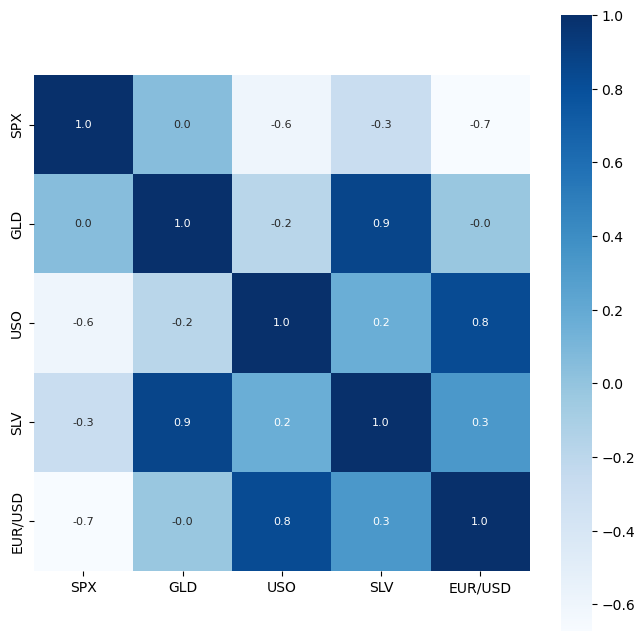

In [69]:
plt.figure(figsize = (8,8))
sns.heatmap(correlation, cbar=True, square=True, fmt='.1f',annot=True, annot_kws={'size':8}, cmap='Blues')

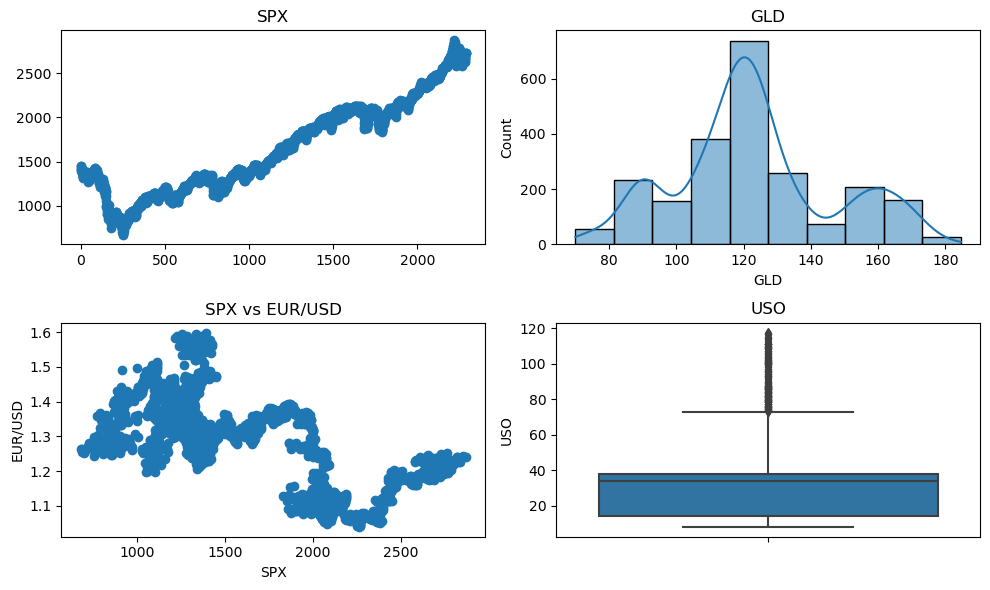

In [88]:
# Planlama yalalım görselleştirme için.
plt.figure(figsize=(10, 6))

# SPX'in zaman içindeki çizgi grafiği
plt.subplot(2, 2, 1)
plt.plot(gold_price_df['SPX'], marker='o', linestyle='-')
plt.title('SPX')

# GLD'nin dağılım grafiği
plt.subplot(2, 2, 2)
sns.histplot(gold_price_df['GLD'], bins=10, kde=True)
plt.title('GLD')

# SPX ve EUR/USD'nin dağılım grafiği
plt.subplot(2, 2, 3)
plt.scatter(gold_price_df['SPX'], gold_price_df['EUR/USD'], marker='o')
plt.xlabel('SPX')
plt.ylabel('EUR/USD')
plt.title('SPX vs EUR/USD')

# USO'nun kutu grafiği
plt.subplot(2, 2, 4)
sns.boxplot(y=gold_price_df['USO'])
plt.title('USO')

plt.tight_layout()
plt.show()

In [89]:
# verileri ve etiketleri ayırma
X = gold_price_df.drop(columns = ['GLD'], axis=1) # Özellik matrisi
y = gold_price_df['GLD'] # Hedef değişken

In [91]:
X

,SPX,USO,SLV,EUR/USD
0,1447.160034,78.470001,15.1800,1.471692
1,1447.160034,78.370003,15.2850,1.474491
2,1411.630005,77.309998,15.1670,1.475492
3,1416.180054,75.500000,15.0530,1.468299
4,1390.189941,76.059998,15.5900,1.557099
...,...,...,...,...
2285,2671.919922,14.060000,15.5100,1.186789
2286,2697.790039,14.370000,15.5300,1.184722
2287,2723.070068,14.410000,15.7400,1.191753
2288,2730.129883,14.380000,15.5600,1.193118


In [92]:
y

0        84.860001
1        85.570000
2        85.129997
3        84.769997
4        86.779999
           ...    
2285    124.589996
2286    124.330002
2287    125.180000
2288    124.489998
2289    122.543800
Name: GLD, Length: 2290, dtype: float64

In [93]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [94]:
scaler.fit(X)

StandardScaler()

In [95]:
standardized_data = scaler.transform(X)

In [96]:
standardized_data

array([[-0.39914541,  2.38880956, -0.6917197 ,  1.42975293],
       [-0.39914541,  2.38368652, -0.67691224,  1.45103511],
       [-0.46760428,  2.32938091, -0.69355301,  1.45864621],
       ...,
       [ 2.05926403, -0.89307824, -0.61274655, -0.69876145],
       [ 2.0728668 , -0.89461519, -0.63813078, -0.68838269],
       [ 2.06448555, -0.89329341, -0.65305106, -0.77266741]])

In [97]:
X = standardized_data

In [98]:
X

array([[-0.39914541,  2.38880956, -0.6917197 ,  1.42975293],
       [-0.39914541,  2.38368652, -0.67691224,  1.45103511],
       [-0.46760428,  2.32938091, -0.69355301,  1.45864621],
       ...,
       [ 2.05926403, -0.89307824, -0.61274655, -0.69876145],
       [ 2.0728668 , -0.89461519, -0.63813078, -0.68838269],
       [ 2.06448555, -0.89329341, -0.65305106, -0.77266741]])

In [99]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

In [100]:
print(X.shape, X_train.shape, X_test.shape)

(2290, 4) (1832, 4) (458, 4)


In [101]:
print(y.shape, y_train.shape, y_test.shape)

(2290,) (1832,) (458,)


In [102]:
# Model Oluşturma İçin
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [103]:
models = [LinearRegression, Lasso, Ridge, SVR, DecisionTreeRegressor, RandomForestRegressor]
mae_scores = []
mse_scores = []
rmse_scores = []
r2_scores = []

for model in models:
    regressor = model().fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    
    mae_scores.append(mean_absolute_error(y_test, y_pred))
    mse_scores.append(mean_squared_error(y_test, y_pred))
    rmse_scores.append(mean_squared_error(y_test, y_pred, squared=False))
    r2_scores.append(r2_score(y_test, y_pred))

In [104]:
regression_metrics_df = pd.DataFrame({
    "Model": ["Linear Regression", "Lasso", "Ridge", "SVR", "Decision Tree Regressor", "Random Forest Regressor"],
    "Mean Absolute Error": mae_scores,
    "Mean Squared Error": mse_scores,
    "Root Mean Squared Error": rmse_scores,
    "R-squared (R2)": r2_scores
})

regression_metrics_df.set_index('Model', inplace=True)
regression_metrics_df

,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error,R-squared (R2)
Model,,,,
Linear Regression,6.119079,69.199813,8.318642,0.871706
Lasso,6.397819,72.040885,8.487690,0.866439
Ridge,6.121224,69.186689,8.317854,0.871731
SVR,3.339882,30.362571,5.510224,0.943709
Decision Tree Regressor,1.742524,14.014292,3.743567,0.974018
Random Forest Regressor,1.320110,5.832795,2.415118,0.989186


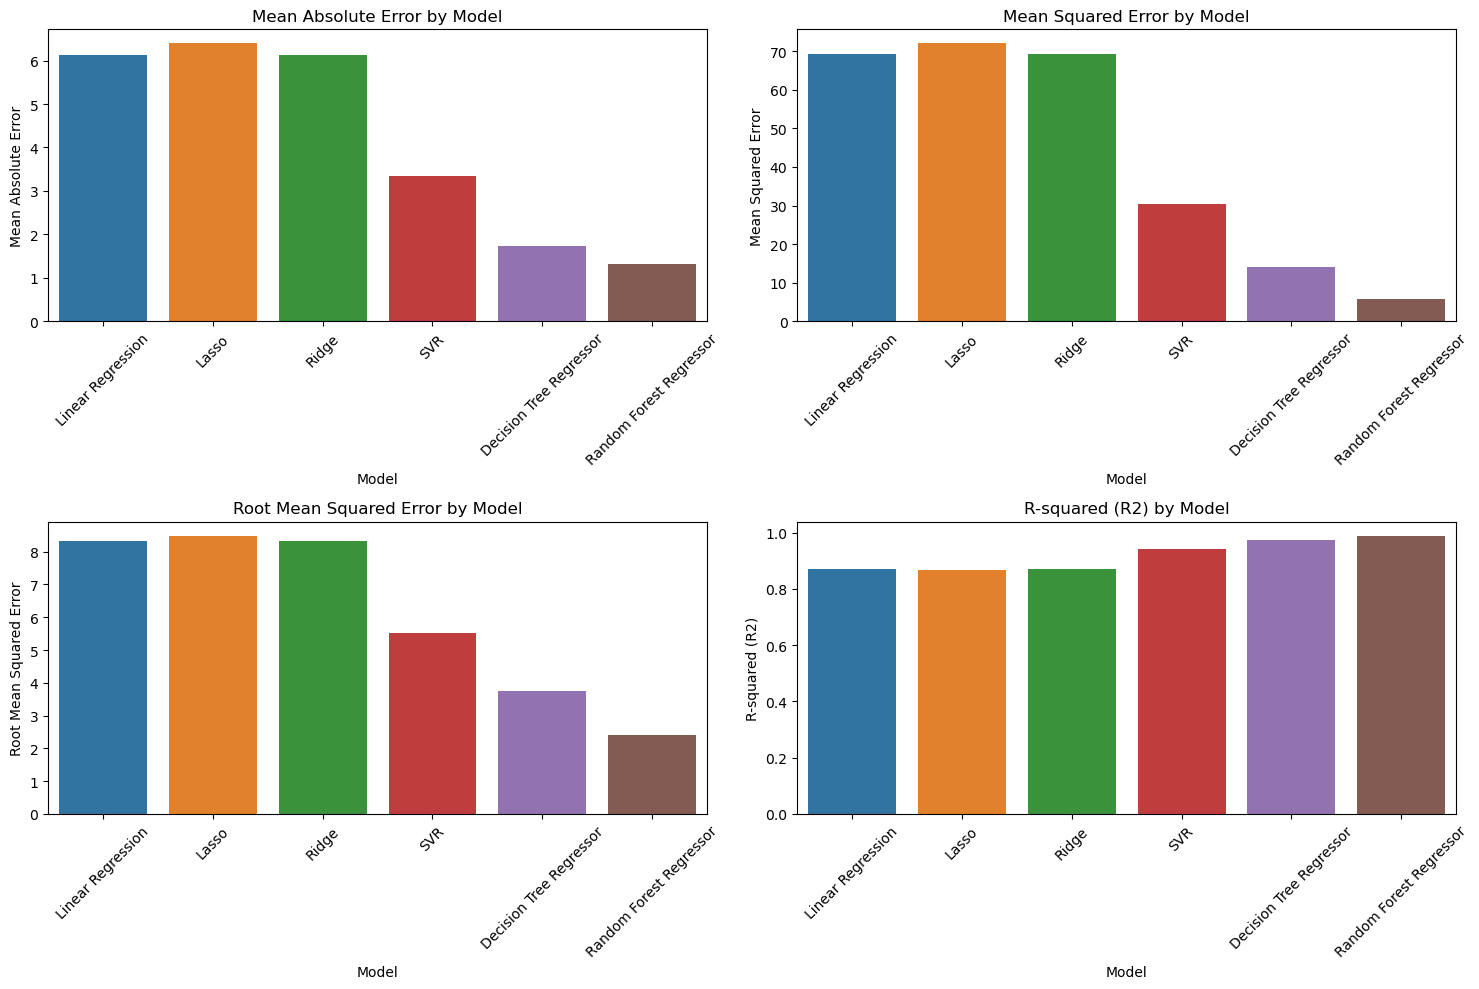

In [105]:
# Veriyi görselleştirmek için tabloyu baştan oluşturmak
regression_metrics_df = pd.DataFrame({
    "Model": ["Linear Regression", "Lasso", "Ridge", "SVR", "Decision Tree Regressor", "Random Forest Regressor"],
    "Mean Absolute Error": mae_scores,
    "Mean Squared Error": mse_scores,
    "Root Mean Squared Error": rmse_scores,
    "R-squared (R2)": r2_scores
})

# Set index back to default for easier plotting
regression_metrics_df.set_index('Model', inplace=True)

# Plotting
plt.figure(figsize=(15, 10))

# MAE
plt.subplot(2, 2, 1)
sns.barplot(x=regression_metrics_df.index, y='Mean Absolute Error', data=regression_metrics_df)
plt.title('Mean Absolute Error by Model')
plt.xticks(rotation=45)

# MSE
plt.subplot(2, 2, 2)
sns.barplot(x=regression_metrics_df.index, y='Mean Squared Error', data=regression_metrics_df)
plt.title('Mean Squared Error by Model')
plt.xticks(rotation=45)

# RMSE
plt.subplot(2, 2, 3)
sns.barplot(x=regression_metrics_df.index, y='Root Mean Squared Error', data=regression_metrics_df)
plt.title('Root Mean Squared Error by Model')
plt.xticks(rotation=45)

# R2
plt.subplot(2, 2, 4)
sns.barplot(x=regression_metrics_df.index, y='R-squared (R2)', data=regression_metrics_df)
plt.title('R-squared (R2) by Model')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()